<a href="https://colab.research.google.com/github/ARMINHOOMAN/DAAI_Real-Time-Anomaly-Segmentation-for-Road-Scenes/blob/main/reformed_KDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
#from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from scipy.stats import multivariate_normal
from scipy.stats import f


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_Confronto_N_p=pd.read_excel('/content/drive/MyDrive/thesis/winter/confronto_N_pure_WN4.xlsx',skiprows=1, sheet_name=None)

In [4]:
def convert_seconds_to_minutes(df):
    # Assuming the DataFrame's index is sequential and starts at 0, representing seconds.
    # If the index is a time series, you can resample it instead.

    # Group the data by each 60-second window and calculate the mean.
    df_minute = df.groupby(df.index // 60).mean(numeric_only=True)

    # If the DataFrame has a 'color' column or any other non-numeric data, we need to handle it separately.
    # For example, here we take the first occurrence within each minute for the 'color' column:
    if 'color' in df.columns:
        df_minute['color'] = df.groupby(df.index // 60)['color'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

    return df_minute

In [5]:
def preprocess_data(df, ks):

    lambda_ewma=0.1
    # Normalize the data using Min-Max Scaler
    scaler = MinMaxScaler()
    df[ks] = scaler.fit_transform(df[ks])

    # Initialize a Series to track rows to remove
    rows_to_remove = pd.Series(data=False, index=df.index)

    for column in ks:
        # Calculate EWMA for each key column
        ewma_series = df[column].ewm(alpha=lambda_ewma).mean()

        # Calculate standard deviation and mean for control limits
        std_dev = df[column].std()
        mean = df[column].mean()
        upper_limit = mean + 2 * std_dev  # Example: z-score of +2
        lower_limit = mean - 2 * std_dev  # Example: z-score of -2

        # Identify rows outside the control limits
        rows_out_of_limits = ((ewma_series > upper_limit) | (ewma_series < lower_limit))
        rows_to_remove = rows_to_remove | rows_out_of_limits

    # Remove rows where at least one key column is outside its control limits
    df_cleaned = df[~rows_to_remove]
    #scaler = MinMaxScaler()
    #df_cleaned [ks] = scaler.fit_transform(df_cleaned[ks])
    return df_cleaned

In [6]:
def concatenated_df(faults, ks):

    all_faults = ['T_RA (°C)', 'T_MA (°C)', 'T_A,out,CC (°C)', 'T_A,out,PostHC (°C)', 'T_SA (°C)',
                          'RH_RA (%)', 'RH_MA (%)', 'RH_A,out,CC (%)', 'RH_A,out,PostHC (%)',
                          'RH_SA (%)', 'T_F,out,CC (°C)', 'T_F,in,CC (°C)', 'T_F,out,PostHC (°C)','T_F,in,PostHC (°C)']
    df_Confronto_columns = [f'confronto_{fault}' for fault in faults]
    #print(df_Confronto_columns)


    color_map = ['red', 'blue', 'green', 'yellow', 'purple', 'cyan','black',"orange",
"brown",
"pink",
"gray",
"maroon",
"lime",
"violet",
"indigo",
"gold",
"silver"]
    if len(faults) > len(color_map):
        print("Please provide more colors or reduce the number of faults.")
        return

    df_list = []
    for i, column_name in enumerate(df_Confronto_columns):
        df = df_Confronto_N_p[column_name].copy()
        df['color'] = color_map[i]
        df_m = convert_seconds_to_minutes(df)
        df_p = preprocess_data(df_m,all_faults)
        #df_p = preprocess_data_(df_m,feature_bins_dict[100000]['Feature'][:2].tolist(),all_faults, 0.1,0.2,8)

        df_p = df_p [ks + ['color']].dropna(subset=ks)

            # Preprocess the dataframe
        ##df = preprocess_data(df, ks)
        df_list.append(df_p)

    df_all = pd.concat(df_list, ignore_index=True)

    return df_all

In [7]:
df_all_N = concatenated_df(['WF1', 'WF2', 'WF3', 'WF4', 'WF5', 'WF6', 'WF7','WN'],
                         ['T_RA (°C)', 'T_MA (°C)', 'T_A,out,CC (°C)', 'T_A,out,PostHC (°C)', 'T_SA (°C)',
                          'RH_RA (%)', 'RH_MA (%)', 'RH_A,out,CC (%)', 'RH_A,out,PostHC (%)',
                          'RH_SA (%)', 'T_F,out,CC (°C)', 'T_F,in,CC (°C)', 'T_F,out,PostHC (°C)','T_F,in,PostHC (°C)'])

In [8]:
def feature_selection(df,n_bins):
  # Discretize each feature into 1000 bins
  discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
  X_discretized = discretizer.fit_transform(df.drop('color', axis=1))
  # Convert the discretized array back to DataFrame with original column names for interpretability
  X_discretized_df = pd.DataFrame(X_discretized, columns=df_all_N.columns[:-1])

  # Split the data into training and test sets
  y_f = df['color']
  X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_discretized_df, y_f, test_size=0.2, random_state=42, shuffle=True)

  # Calculate mutual information scores for the discretized features in the training set
  mi_scores = mutual_info_classif(X_train_f, y_train_f)

  # Creating a DataFrame to display features and their corresponding mutual information scores
  mi_scores_df = pd.DataFrame({'Feature': X_train_f.columns, 'MI Score': mi_scores})

  # Sorting the DataFrame by MI Score in descending order
  mi_scores_sorted = mi_scores_df.sort_values(by='MI Score', ascending=False).reset_index(drop=True)

  return mi_scores_sorted[:]

In [9]:
def assess_features_across_bins(df, n_bins_range):
    results_dict = {}

    for n_bins in n_bins_range:
        selected_features_df = feature_selection(df, n_bins)
        results_dict[n_bins] = selected_features_df

        # Create a wandb.Table and add data to it
        #table = wandb.Table(columns=["Feature", f"MI Score for {n_bins} bins"])
       #for i, row in selected_features_df.iterrows():
            #table.add_data(row['Feature'], row['MI Score'])

        # Log the table to wandb
        #wandb.log({f"mi_scores_table_{n_bins}": table})

    return results_dict


# Example usage:
# Assuming df is your DataFrame and n_bins_range is defined as np.logspace(0,5,20).astype(int)
n_bins_range = np.logspace(1, 5, 20).astype(int)
feature_bins_dict = assess_features_across_bins(df_all_N, n_bins_range)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:2

In [10]:
def feature_selecetd__dataframe( n_bins, n_features):
  selected_features = []
  for i in range(n_features):
    # Append the feature name to the selected_features list
    selected_features.append(feature_bins_dict[n_bins].iloc[i]['Feature'])
  df_all_f = concatenated_df(['WF1', 'WF2', 'WF3', 'WF4', 'WF5', 'WF6', 'WF7','WN'], selected_features)


  # Now selected_features is a list of feature names
  return df_all_f, selected_features

In [11]:
def train_test_results_ ( n_features):
  # Mapping colors to faults and preparing the dataset
  faults = ['WF1', 'WF2', 'WF3', 'WF4', 'WF5', 'WF6', 'WF7', 'WN']
  color_map = ['red', 'blue', 'green', 'yellow', 'purple', 'cyan', 'black', "orange",
                "brown", "pink", "gray", "maroon", "lime", "violet", "indigo", "gold", "silver"]
  color_to_fault = dict(zip(color_map, faults))
  # ...
  df_minute, selected_features = feature_selecetd__dataframe(100000, n_features)
  df_minute['label'] = df_minute['color'].map(color_to_fault)
  X = df_minute[selected_features]
  y = df_minute['label']

  # Splitting the dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  final_df_train = pd.concat([X_train, y_train], axis=1)
  final_df_test = pd.concat([X_test, y_test], axis=1)  # Combine with y_test for the labels

  return final_df_train,final_df_test

In [12]:
final_df_train,final_df_test = train_test_results_ ( 10)

In [13]:
def KDE_results(df_train_final, df_test_final, bandwidth, lp):
    # Splitting the dataset
    X_train, X_test, y_train, y_test = df_train_final.drop('label', axis=1), df_test_final.drop('label', axis=1), df_train_final['label'], df_test_final['label']
    accuracies = []

    # Define sorted labels
    sorted_labels = ['WF1', 'WF2', 'WF3', 'WF4', 'WF5', 'WF6', 'WF7', 'WN']
    # Train KDE models for each label
    kde_models = {}
    for label in sorted_labels:
        kde_models[label] = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_train[y_train == label])

    # Predict the label for the validation set
    log_prob = np.array([kde_models[label].score_samples(X_test) for label in sorted_labels]).T

    # Compute and normalize the probabilities
    probabilities = np.exp(log_prob - log_prob.max(axis=1)[:, np.newaxis])
    probabilities /= probabilities.sum(axis=1)[:, np.newaxis]

    # Create a DataFrame to store probabilities with corresponding labels
    prob_df = pd.DataFrame(probabilities, columns=sorted_labels)

    # Modify prediction logic with lp check for 'WN'
    predictions = []
    wn_index = sorted_labels.index('WN')  # Get the index of 'WN' in the sorted labels
    for prob in prob_df.values:
        if prob[wn_index] > lp:
            predictions.append('WN')
        else:
            predictions.append(sorted_labels[np.argmax(prob)])

    accuracies.append(accuracy_score(y_test, predictions))

    # Confusion matrix with sorted labels
    conf_matrix = confusion_matrix(y_test, predictions, labels=sorted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=sorted_labels, yticklabels=sorted_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f' n_features={df_train_final.shape[1]-1} , bandwidth={bandwidth}, lp={lp}')
    #plt.show()

    return accuracies[0], predictions

['WF3',
 'WF5',
 'WF4',
 'WF2',
 'WF5',
 'WF2',
 'WN',
 'WF2',
 'WF2',
 'WF3',
 'WF5',
 'WF5',
 'WF5',
 'WF4',
 'WF3',
 'WF1',
 'WF2',
 'WF3',
 'WF2',
 'WF3',
 'WF4',
 'WF3',
 'WF3',
 'WF3',
 'WF3',
 'WF6',
 'WF5',
 'WF5',
 'WF2',
 'WF2',
 'WF5',
 'WN',
 'WF6',
 'WN',
 'WF5',
 'WN',
 'WF2',
 'WF6',
 'WF1',
 'WF3',
 'WF1',
 'WF7',
 'WF6',
 'WF5',
 'WF1',
 'WF3',
 'WF4',
 'WF2',
 'WF3',
 'WF5',
 'WF3',
 'WF5',
 'WF7',
 'WF3',
 'WF1',
 'WF1',
 'WF2',
 'WF5',
 'WF5',
 'WF6',
 'WF1',
 'WF3',
 'WF1',
 'WF2',
 'WF2',
 'WF5',
 'WF3',
 'WF5',
 'WN',
 'WF5',
 'WF2',
 'WF4',
 'WF1',
 'WN',
 'WF7',
 'WF5',
 'WN',
 'WF5',
 'WF5',
 'WF3',
 'WF7',
 'WF5',
 'WN',
 'WF3',
 'WF2',
 'WF5',
 'WF1',
 'WF6',
 'WN',
 'WN',
 'WF6',
 'WF1',
 'WF2',
 'WF3',
 'WN',
 'WF1',
 'WF3',
 'WF7',
 'WN',
 'WF2',
 'WF6',
 'WF5',
 'WN',
 'WF1',
 'WF6',
 'WN',
 'WF7',
 'WF4',
 'WF2',
 'WF1',
 'WF5',
 'WF3',
 'WF5',
 'WF6',
 'WF5',
 'WF6',
 'WF5',
 'WF2',
 'WF5',
 'WF1',
 'WF5',
 'WN',
 'WN',
 'WN',
 'WF1',
 'WF3',
 'WF5',
 

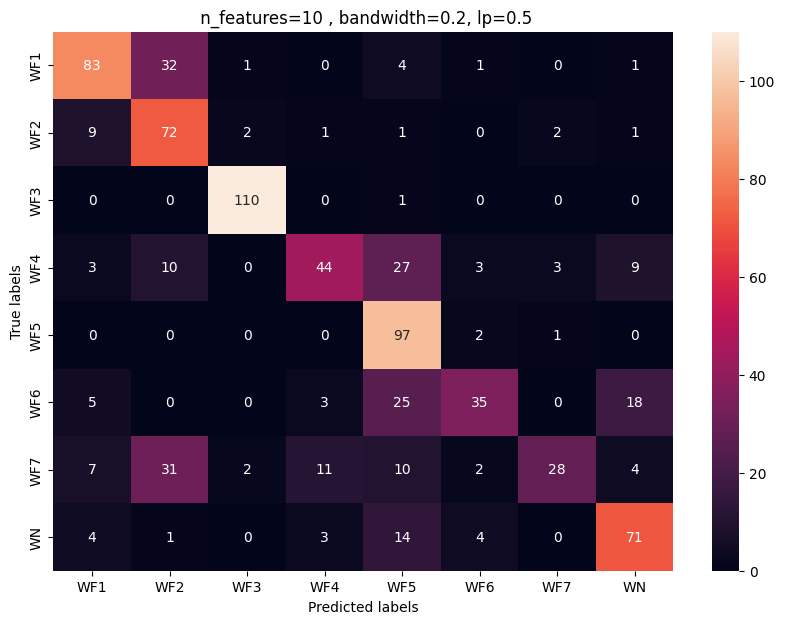

In [14]:
KDE_results ( final_df_train,  final_df_test, 0.2,0.5)[1]

In [15]:
def calculate_vlm(conf_matrix, loss_matrix):
    """
    Calculate the Validation Metric VLM(CM) using the confusion matrix and loss matrix.
    """
    weighted_correct = np.sum(np.diagonal(conf_matrix) * np.diagonal(loss_matrix))
    total_weighted = np.sum(conf_matrix * loss_matrix)
    return weighted_correct / total_weighted

In [16]:
bandwidth_range = np.array ([0.01,0.02,0.05,0.1])
n_features_values = np.array([5,10,14])
lp_values = np.array([0.05,0.1,0.2,1])
loss_matrix = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1, 1, 1, 1],
                        [10, 10, 10, 10, 10, 10, 10, 1]])

In [17]:
def cross_validate_KDE( n_features_values , bandwidth_range,loss_matrix, lp_values):


    accuracies = []
    for lp in lp_values:
     for n_features in n_features_values:
      for bandwidth in bandwidth_range:
          df_selected, selected_features = feature_selecetd__dataframe(100000, n_features)
          df_train_final , df_test_final = train_test_results_ ( n_features)


          X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(
          df_train_final.drop('label', axis=1), df_train_final['label'], test_size=0.4, random_state=42)

          # Combine train fold with validation labels for TAN_accuracy function
          df_train_fold = X_train_fold.copy()
          df_train_fold['label'] = y_train_fold

          df_val_fold = X_val_fold.copy()
          df_val_fold['label'] = y_val_fold

          conf_labels = np.unique(y_train_fold)

          accuracy , y_pred = KDE_results(df_train_fold, df_val_fold, bandwidth,lp)

          conf_matrix = confusion_matrix(y_val_fold, y_pred,labels=conf_labels)
          lm = calculate_vlm(conf_matrix, loss_matrix)
          # Calculate FAR
          y_pred = np.array(y_pred)
          y_val_fold = np.array(y_val_fold)
          false_alarms = sum((y_pred != 'WN') & (y_val_fold == 'WN'))
          total_predicted_wn = sum(y_val_fold == 'WN')
          far = false_alarms / total_predicted_wn if total_predicted_wn > 0 else 0

          accuracies.append(( n_features, bandwidth, lp , accuracy,conf_matrix,far,lm))
    return accuracies

<ipython-input-13-8827f4fd2f78>:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 7))
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-6657e604b1c6>", line 1, in <cell line: 1>
    data = cross_validate_KDE( n_features_values , bandwidth_range,loss_matrix, lp_values)
  File "<ipython-input-17-9ff11af04c71>", line 8, in cross_validate_KDE
    df_selected, selected_features = feature_selecetd__dataframe(100000, n_features)
  File "<ipython-input-10-a06e887b174b>", line 6, in feature_selecetd__dataframe
    df_all_f = concatenated_df(['WF1', 'WF2', 'WF3', 'WF4', 'WF5', 'WF6', 'WF7','WN'], selected_features)
  File "<ipython-input-6-1d71adb76891>", line 28, in concatenated_df
    df_m = convert_seconds_to_minutes(df)
  File "<ipython-input-4-bea5f9c0067f>", line 11, in convert_seconds_to_minutes
    df_minute['color'] = df.groupby(df.index // 60)['color'].agg(lambda x: x.mode()[0] if not x.mode().empty el

TypeError: object of type 'NoneType' has no len()

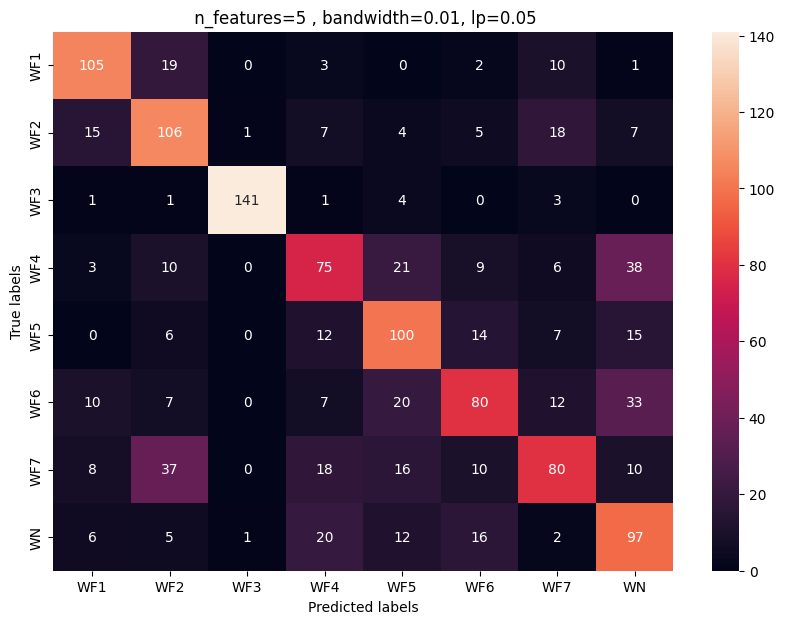

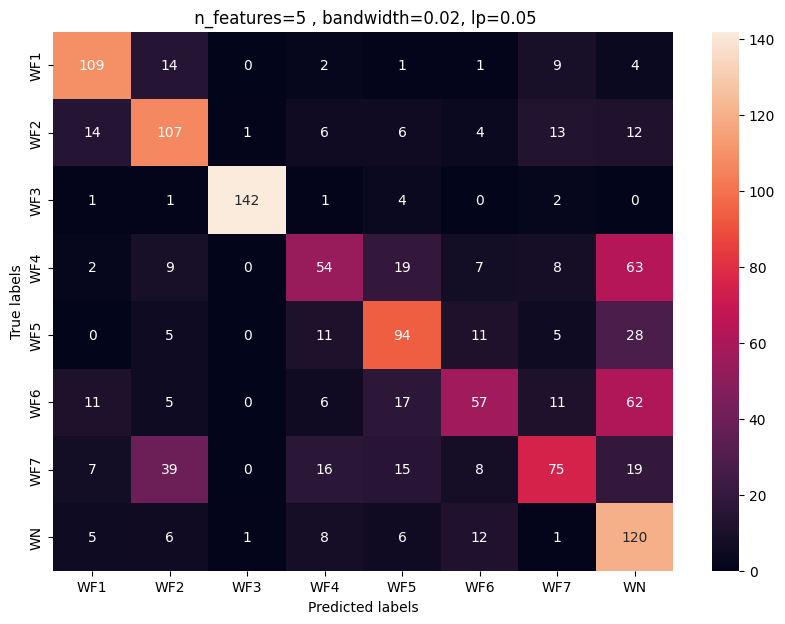

Error in callback <function flush_figures at 0x7c82dd07a440> (for post_execute):


KeyboardInterrupt: 

In [18]:
data = cross_validate_KDE( n_features_values , bandwidth_range,loss_matrix, lp_values)
df_results = pd.DataFrame(data, columns=['n_features', 'bandwidth', 'lp' , 'accuracy','conf_matrix','far','lm'])
df_results = df_results.sort_values(by=['n_features', 'bandwidth'], ascending=[True, True])

In [ ]:
df_results = df_results.sort_values(by=['n_features', 'bandwidth'], ascending=[True, True])

In [ ]:
df_results

,n_features,bandwidth,lp,accuracy,conf_matrix,far,lm
0,5,0.01,0.05,0.614722,"[[105, 19, 0, 3, 0, 2, 10, 1], [15, 106, 1, 7,...",0.389937,0.427793
12,5,0.01,0.10,0.615505,"[[105, 19, 0, 3, 0, 2, 10, 1], [15, 106, 1, 7,...",0.415094,0.420096
24,5,0.01,0.20,0.615505,"[[105, 19, 0, 3, 0, 2, 10, 1], [15, 109, 1, 7,...",0.452830,0.408312
36,5,0.01,1.00,0.613156,"[[105, 19, 0, 3, 0, 2, 10, 1], [15, 109, 1, 7,...",0.528302,0.385145
1,5,0.02,0.05,0.593579,"[[109, 14, 0, 2, 1, 1, 9, 4], [14, 107, 1, 6, ...",0.245283,0.465602
13,5,0.02,0.10,0.608457,"[[110, 14, 0, 2, 1, 1, 9, 3], [14, 109, 1, 6, ...",0.289308,0.459491
25,5,0.02,0.20,0.612373,"[[110, 14, 0, 2, 1, 1, 9, 3], [14, 110, 1, 6, ...",0.371069,0.432522
37,5,0.02,1.00,0.621770,"[[111, 14, 0, 2, 1, 1, 9, 2], [14, 112, 1, 6, ...",0.496855,0.399396
2,5,0.05,0.05,0.482381,"[[96, 15, 0, 0, 0, 1, 5, 23], [19, 91, 1, 1, 2...",0.113208,0.428075
14,5,0.05,0.10,0.505090,"[[105, 18, 0, 0, 1, 1, 5, 10], [22, 96, 1, 2, ...",0.163522,0.426870


In [ ]:
from google.colab import files

csv_filename = 'reformed_KDE_cross_validation.csv'
df_results.to_csv(csv_filename, index=False)

# Download the file to your local computer
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def final_evaluation(df_Confronto_N, data, loss_matrix):

    sorted_labels = ['WF1', 'WF2', 'WF3', 'WF4', 'WF5', 'WF6', 'WF7', 'WN']
    final_results = []

    # Find the best row for each 'n_features'
    for n_features in data['n_features'].unique():
        best_rows = []
        features = feature_bins_dict[100000]['Feature'][:n_features].tolist()
        best_row = data[data['n_features'] == n_features].sort_values(by='lm', ascending=False).iloc[0]
        df_train_final, df_test_final = train_test_results_ ( n_features)
        best_rows.append(best_row)

        # Convert to DataFrame
        best_rows_df = pd.DataFrame(best_rows)

        # Evaluate the model for each best row and calculate the metrics

        for _, row in best_rows_df.iterrows():
            n_features = row['n_features']
            bandwidth = row['bandwidth']
            lp = row['lp']
            #n_features, alpha , accuracy,conf_matrix,far,lm


            # Assuming result_with_manual_cgn_and_lp is a function that returns accuracy and y_pred
            accuracy, y_pred = KDE_results(df_train_final, df_test_final, bandwidth, lp)  # Modify as needed

            accuracy_baseline , y_pred_baseline = KDE_results(df_train_final, df_test_final, bandwidth, 1)

            # Create confusion matrix
            conf_matrix = confusion_matrix(df_test_final['label'], y_pred, labels=sorted_labels)
            conf_matrix_baseline = confusion_matrix(df_test_final['label'], y_pred_baseline, labels=sorted_labels)
            # Calculate VLM
            lm = calculate_vlm(conf_matrix, loss_matrix)
            lm_baseline = calculate_vlm(conf_matrix_baseline, loss_matrix)

            # Calculate FAR
            y_pred , y_pred_baseline = np.array(y_pred) , np.array(y_pred_baseline)
            y_test = np.array(df_test_final['label'])
            false_alarms , false_alarms_baseline = sum((y_pred != 'WN') & (y_test == 'WN')) , sum((y_pred_baseline != 'WN') & (y_test == 'WN'))
            total_predicted_wn = sum(y_test == 'WN')
            far , far_baseline = false_alarms / total_predicted_wn if total_predicted_wn > 0 else 0 ,  false_alarms_baseline / total_predicted_wn if total_predicted_wn > 0 else 0

            final_results.append((n_features, bandwidth, lp , accuracy,conf_matrix,far,lm))
            final_results.append((n_features, bandwidth, 1, accuracy_baseline,conf_matrix_baseline ,far_baseline,lm_baseline))

        # Convert final results to DataFrame
        final_df = pd.DataFrame(final_results, columns=['n_features', 'bandwidth', 'lp' , 'accuracy','conf_matrix','far','lm'])

    return final_df

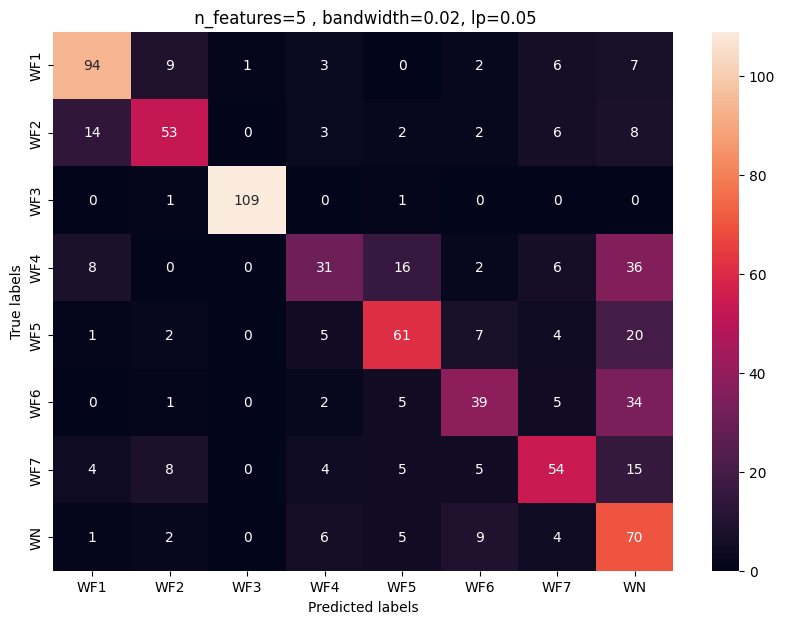

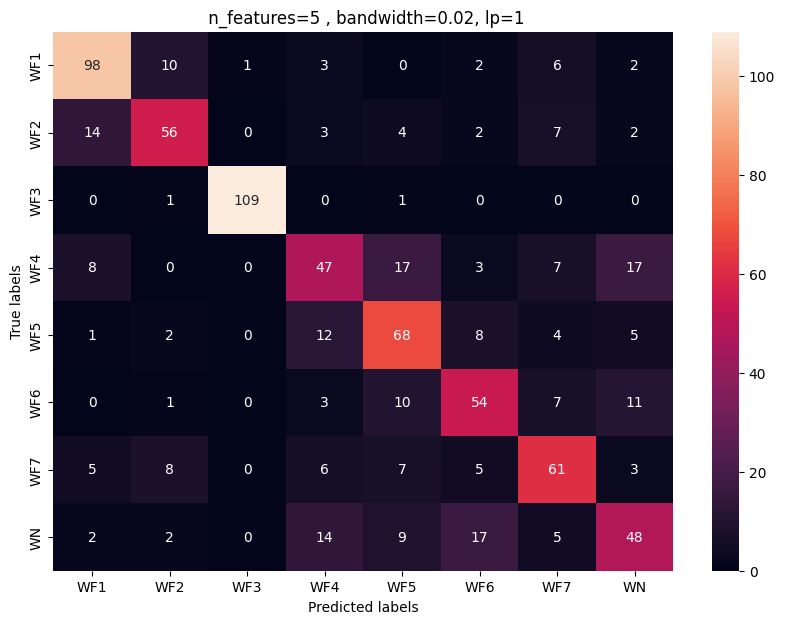

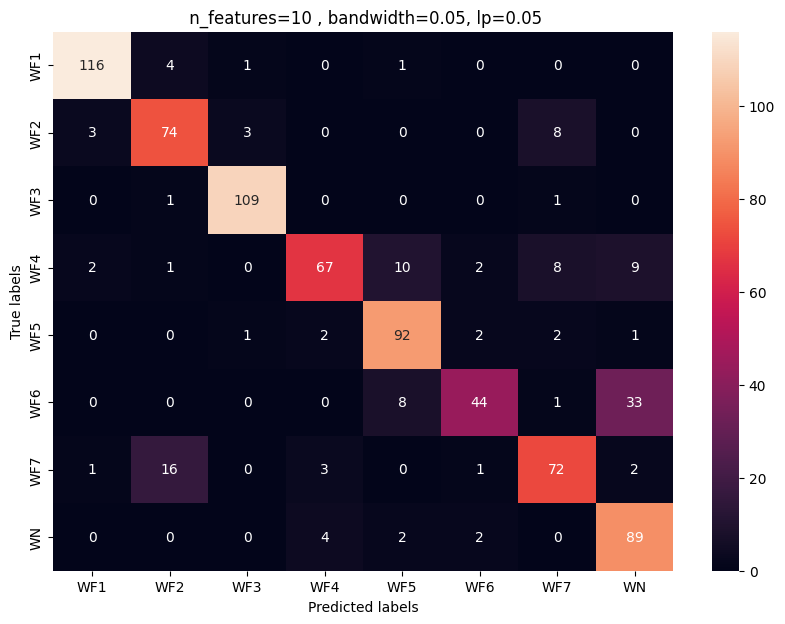

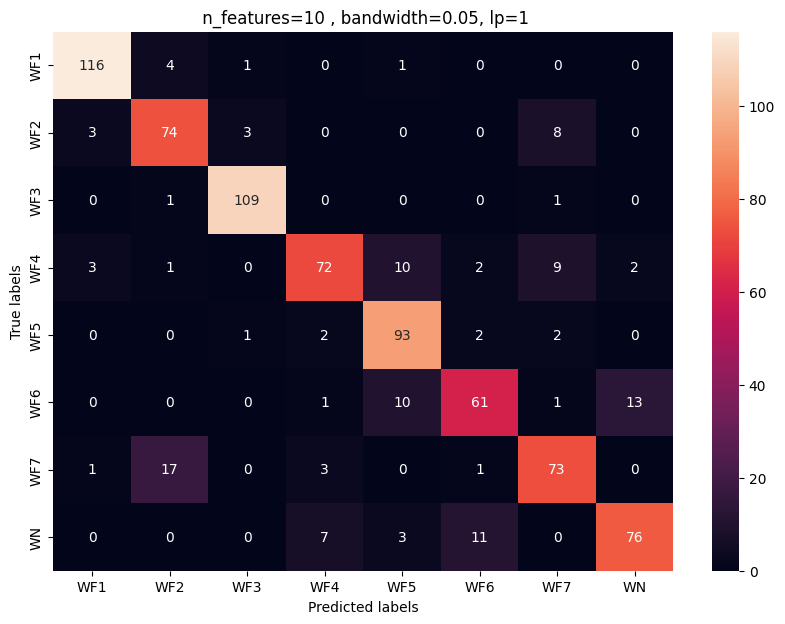

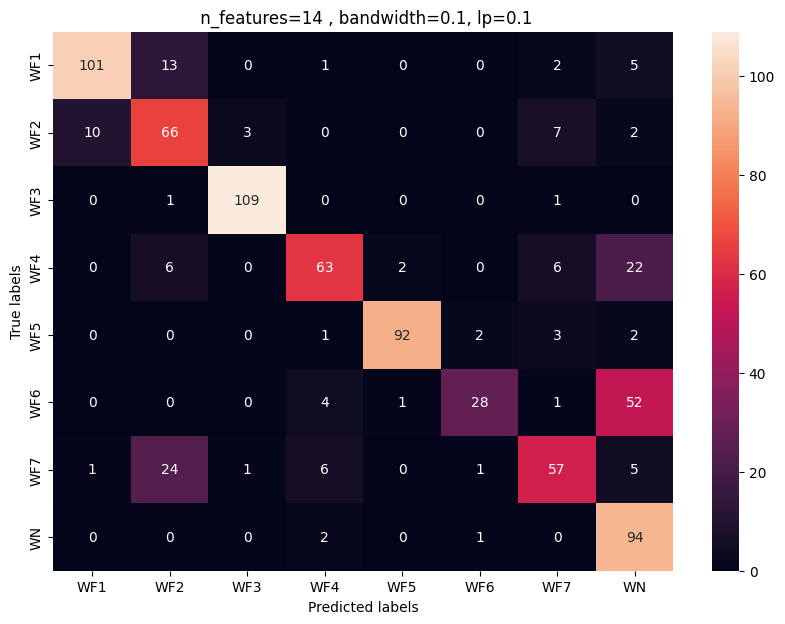

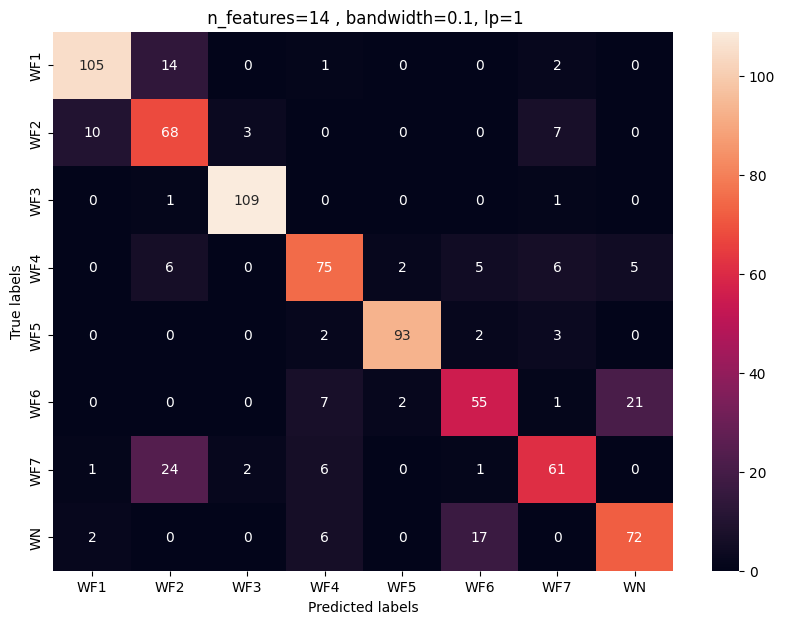

In [ ]:
df_final = final_evaluation(df_Confronto_N_p, df_results, loss_matrix)

In [ ]:
df_final

,n_features,bandwidth,lp,accuracy,conf_matrix,far,lm
0,5,0.02,0.05,0.640351,"[[94, 9, 1, 3, 0, 2, 6, 7], [14, 53, 0, 3, 2, ...",0.278351,0.490874
1,5,0.02,1.00,0.677945,"[[98, 10, 1, 3, 0, 2, 6, 2], [14, 56, 0, 3, 4,...",0.505155,0.436642
2,10,0.05,0.05,0.830827,"[[116, 4, 1, 0, 1, 0, 0, 0], [3, 74, 3, 0, 0, ...",0.082474,0.762069
3,10,0.05,1.00,0.844612,"[[116, 4, 1, 0, 1, 0, 0, 0], [3, 74, 3, 0, 0, ...",0.216495,0.682877
4,14,0.10,0.10,0.764411,"[[101, 13, 0, 1, 0, 0, 2, 5], [10, 66, 3, 0, 0...",0.030928,0.739394
5,14,0.10,1.00,0.799499,"[[105, 14, 0, 1, 0, 0, 2, 0], [10, 68, 3, 0, 0...",0.257732,0.623656


In [ ]:
from google.colab import files

csv_filename = 'reformed_KDE_final.csv'
df_results.to_csv(csv_filename, index=False)

# Download the file to your local computer
files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>